In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/MUFG2023"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")
OOF_DIR = os.path.join(OUTPUT_DIR, 'oof')
SUB_NUM_DIR = os.path.join(OUTPUT_DIR, 'sub_num')
OUTPUT_EXP21_DIR = DIR + '/output/EXP021/'

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
!pip install catboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import f1_score, accuracy_score
import lightgbm as lgb
import xgboost as xgb
from catboost import *
import catboost as ctb
from catboost import Pool
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold

In [4]:
def get_f1_score(labels, outputs):
    y_pred = outputs
    y_true = labels
    best_score = 0
    best_thresh = 0.5
    for thresh in np.arange(0.1, 0.80, 0.01):
        thresh = np.round(thresh, 2)
        score = f1_score(y_true, (y_pred>thresh).astype(int))
        #print("Accuracy score at threshold {0} is {1}".format(thresh, score))
        if score > best_score:
          best_score = score
          best_thresh = thresh
    return f1_score(y_true, (y_pred>best_thresh).astype(int))

In [5]:
class CFG1:
  ver=18
  model="catboost"
  seed=42

class CFG2:
  ver=19
  model="lightgbm"
  seed=42

class CFG3:
  ver=20
  model="xgboost"
  seed=42

class CFG4:
  ver=21
  model="microsoft/deberta-v3-base"
  seed=42
  path=OUTPUT_EXP21_DIR
  config_path=path+'config.pth'

In [6]:
class CFG:
  debug=False
  ver=23
  model="stacking"
  n_folds=5
  trn_fold=[0, 1, 2, 3, 4]
  seed=42
  target= "is_fraud?"
  boosting_type="gbdt"
  early_stopping_round=50
  verbose=200

In [7]:
oof_df1 = pd.read_csv(os.path.join(OOF_DIR, f'oof_{CFG1.model}_ver{CFG1.ver}.csv'))
oof_df1.rename(columns={"pred":"pred1"},inplace=True)
oof_df2 = pd.read_csv(os.path.join(OOF_DIR, f'oof_{CFG2.model}_ver{CFG2.ver}.csv'))
oof_df2.rename(columns={"pred":"pred2"},inplace=True)
oof_df3 = pd.read_csv(os.path.join(OOF_DIR, f'oof_{CFG3.model}_ver{CFG3.ver}.csv'))
oof_df3.rename(columns={"pred":"pred3"},inplace=True)
oof_df4 = pd.read_pickle(CFG4.path+'oof_df.pkl')
oof_df4.rename(columns={"pred":"pred4"},inplace=True)

In [8]:
test_pred1 = pd.read_csv(os.path.join(SUB_NUM_DIR, f'submit_num_{CFG1.model}_ver{CFG1.ver}.csv'),header=None)[1]
test_pred2 = pd.read_csv(os.path.join(SUB_NUM_DIR, f'submit_num_{CFG2.model}_ver{CFG2.ver}.csv'),header=None)[1]
test_pred3 = pd.read_csv(os.path.join(SUB_NUM_DIR, f'submit_num_{CFG3.model}_ver{CFG3.ver}.csv'),header=None)[1]
test_pred4 = pd.read_csv(os.path.join(SUB_NUM_DIR, f"submit_num_{CFG4.model.replace('/', '-')}_seed{CFG4.seed}_ver{CFG4.ver}.csv"), header=None)[1]

test_pred = pd.read_csv(os.path.join(INPUT_DIR,"sample_submit.csv"), header=None)
test_pred.columns = ["index", "label"]
test_pred["model1"] = test_pred1
test_pred["model2"] = test_pred2
test_pred["model3"] = test_pred3
test_pred["model4"] = test_pred4

In [9]:
oof_df = oof_df1.merge(oof_df2[["index","pred2"]], how="left", on="index").merge(oof_df3[["index","pred3"]], how="left", on="index").merge(oof_df4[["index","pred4"]], how="left", on="index")

oof_df["model1"] = oof_df["pred1"].values
oof_df["model2"] = oof_df["pred2"].values
oof_df["model3"] = oof_df["pred3"].values
oof_df["model4"] = oof_df["pred4"].values

In [10]:
preds_df = oof_df[["is_fraud?","model1","model2","model3", "model4"]].copy()
display(preds_df.corr())
print(preds_df.shape)
preds_df.dropna(axis=0,inplace=True)
print(preds_df.shape)
y_true = preds_df["is_fraud?"].values

,is_fraud?,model1,model2,model3,model4
is_fraud?,1.000000,0.709066,0.706214,0.686727,0.574390
model1,0.709066,1.000000,0.955942,0.954919,0.796970
model2,0.706214,0.955942,1.000000,0.948713,0.785123
model3,0.686727,0.954919,0.948713,1.000000,0.815857
model4,0.574390,0.796970,0.785123,0.815857,1.000000


(471283, 5)
(471283, 5)


In [11]:
for i in range(4):
  score = get_f1_score(y_true, preds_df[f"model{i+1}"])
  print(f"model{i+1} : {score}")

model1 : 0.672034188034188
model2 : 0.6709376042709377
model3 : 0.6451733514615908
model4 : 0.5356618952764782


In [12]:
skf = StratifiedKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
for fold, (train_index, valid_index) in enumerate(skf.split(preds_df, preds_df[CFG.target])):
    preds_df.loc[valid_index, "fold"] = fold
preds_df['fold'] = preds_df['fold'].astype(int)
display(preds_df.groupby('fold').size())

if CFG.debug:
    display(preds_df.groupby('fold').size())
    preds_df = preds_df.sample(n=1000, random_state=0).reset_index(drop=True)
    display(preds_df.groupby('fold').size())

fold
0    94257
1    94257
2    94257
3    94256
4    94256
dtype: int64

In [13]:
lgb_params = {
        'objective': 'binary',
        #'metric': 'logloss',
        'learning_rate': 0.05,
        'boosting': CFG.boosting_type,
        'seed': CFG.seed,
        "reg_alpha":0.1,
        "n_estimators":8000,
    }

ctb_params = {
        "n_estimators":8000,
        "learning_rate":0.05,
        'depth': 4,
        "random_state":CFG.seed,
        'colsample_bylevel': 0.50,
        'subsample': 0.80,
        'l2_leaf_reg': 3,
    }

features = ["model1", "model2", "model3", "model4"]
oofs = pd.DataFrame()
test_preds_lgb = np.zeros(len(test_pred))
test_preds_cat = np.zeros(len(test_pred))

for fold in range(CFG.n_folds):
  if fold in CFG.trn_fold:
    print("="*15,f" FOLD : {fold} ","="*15)
    train_folds = preds_df[preds_df['fold'] != fold].reset_index(drop=True)
    valid_folds = preds_df[preds_df['fold'] == fold].reset_index(drop=True)

    train_X = train_folds[features]
    valid_X = valid_folds[features]
    test_X = test_pred[features]
    train_labels = train_folds[CFG.target].values
    valid_labels = valid_folds[CFG.target].values

    lgb_model = lgb.LGBMClassifier(**lgb_params)
    lgb_model.fit(train_X, train_labels,
            eval_set=[(valid_X, valid_labels)],
            eval_metric="log_loss",
            callbacks=[
            lgb.early_stopping(stopping_rounds=CFG.early_stopping_round, verbose=True),
            lgb.log_evaluation(CFG.verbose),
        ],
            )

    valid_folds["lgb_pred"] = lgb_model.predict_proba(valid_X)[:, 1]
    test_preds_lgb += lgb_model.predict_proba(test_X)[:, 1]

    lgb_pred = np.where(valid_folds["lgb_pred"]>0.5, 1, 0)
    lgb_scoref1 =  f1_score(valid_labels, lgb_pred)
    print(f"LGB F1 Score : {lgb_scoref1}")

    train_pool = Pool(train_X,
                     label=train_labels)
    valid_pool = Pool(valid_X,
                    label=valid_labels)

    ctb_model = ctb.CatBoostClassifier(**ctb_params)
    ctb_model.fit(train_pool,
              eval_set=[valid_pool],
              early_stopping_rounds=CFG.early_stopping_round,
              verbose=CFG.verbose,
              use_best_model=True)

    valid_folds["ctb_pred"] = ctb_model.predict_proba(valid_pool)[:, 1]
    test_preds_cat += ctb_model.predict_proba(Pool(test_X))[:, 1]

    ctb_pred = np.where(valid_folds["ctb_pred"]>0.5, 1, 0)
    ctb_scoref1 =  f1_score(valid_labels, ctb_pred)
    print(f"CTB F1 Score : {ctb_scoref1}")

    oofs = pd.concat([oofs, valid_folds])
    del lgb_model, ctb_model, train_folds, valid_folds, train_X, valid_X, test_X, train_pool, valid_pool, ctb_pred, lgb_pred

===============  FOLD : 0  ===============
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Number of positive: 26105, number of negative: 350921
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 4
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069239 -> initscore=-2.598434
[LightGBM] [Info] Start training from score -2.598434
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.11856

In [14]:
oof_pred = oofs["lgb_pred"]*.4 + oofs["ctb_pred"]*.6

In [15]:
best_score = 0
best_thresh = 0.5
for thresh in np.arange(0.10, 0.801, 0.01):
    thresh = np.round(thresh, 2)
    score = f1_score(oofs[CFG.target], (oof_pred>thresh).astype(int))
    print("F1 score at threshold {0} is {1}".format(thresh, score))
    if score > best_score:
      best_score = score
      best_thresh = thresh
print()
print("best F1 score at threshold {0} is {1}".format(best_thresh, f1_score(oofs[CFG.target], (oof_pred>best_thresh).astype(int))))

F1 score at threshold 0.1 is 0.5722807804440457
F1 score at threshold 0.11 is 0.5878887070376432
F1 score at threshold 0.12 is 0.6028199829828613
F1 score at threshold 0.13 is 0.613655464820181
F1 score at threshold 0.14 is 0.6223069295455423
F1 score at threshold 0.15 is 0.630730398699634
F1 score at threshold 0.16 is 0.6387615764212803
F1 score at threshold 0.17 is 0.6446367689483347
F1 score at threshold 0.18 is 0.650116740273988
F1 score at threshold 0.19 is 0.6548753613233737
F1 score at threshold 0.2 is 0.6588361693478134
F1 score at threshold 0.21 is 0.6624770034586798
F1 score at threshold 0.22 is 0.6652946790742066
F1 score at threshold 0.23 is 0.6684821252969031
F1 score at threshold 0.24 is 0.6714913493746352
F1 score at threshold 0.25 is 0.6743809375486685
F1 score at threshold 0.26 is 0.6754428785135029
F1 score at threshold 0.27 is 0.6770345189115343
F1 score at threshold 0.28 is 0.6781137878011277
F1 score at threshold 0.29 is 0.6791362726744561
F1 score at threshold 0.3

In [16]:
pred_lgb = test_preds_lgb / CFG.n_folds
pred_ctb = test_preds_cat / CFG.n_folds

,0,1
0,471283,0
1,471284,0
2,471285,0
3,471286,1
4,471287,0


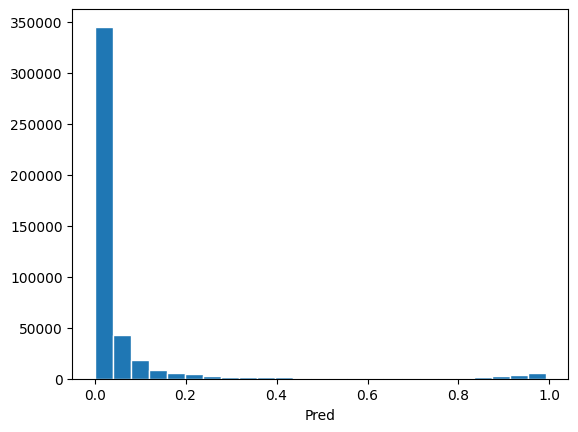

,0,1
0,471283,0
1,471284,0
2,471285,0
3,471286,1
4,471287,0
...,...,...
457953,929236,0
457954,929237,0
457955,929238,0
457956,929239,0


0    430583
1     27375
Name: 1, dtype: int64

In [17]:
submit = pd.read_csv(os.path.join(INPUT_DIR,"sample_submit.csv"), header=None)
pred = pred_lgb*.4 + pred_ctb*.6
submit[1] = (pred>best_thresh).astype(int)

submit.to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_ver{CFG.ver}.csv'), index=False, header=None)
display(submit.head())

plt.hist(pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(submit)
display(submit[1].value_counts())